# Age Cross-Prediction

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [43]:
from common.data import get_data

X, Y, demographics, population = get_data(wisc_level=5)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (390, 34716) | Y: 6 | Age: (390,) | Population: adhd


In [44]:
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold, cross_validate, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Run for one target, one age bin

In [45]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'{selected_target}: {y.shape}')

WISC_FSIQ: (390,)


In [46]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 1: (117, 34716) | Bin 2: (156, 34716) | Bin 3: (117, 34716)


### Set up the model pipeline, metrics, and cross-validation approach

In [6]:
def regression_scorer(reg, X, y):
#     y_pred = reg.predict(X)
    y_pred = reg.predict(X)[:, 0]
    return stats.pearsonr(y, y_pred)[0]

rkf = RepeatedKFold(n_splits=10, n_repeats=10)

In [27]:
%%time

estimators = [StandardScaler(), RidgeCV(alphas=[a for a in range(5000, 55000, 5000)], 
                                        scoring=regression_scorer, cv=rkf)]
pipe = make_pipeline(*estimators)
pipe.fit(X, y)
ridge_cv = pipe['ridgecv']
best_alpha = ridge_cv.alpha_

print(f'Target: {selected_target} | Alpha: {best_alpha} | Score: {ridge_cv.best_score_:.2f}')

Target: WISC_FSIQ | Alpha: 25000 | Score: 0.35
CPU times: user 1min 37s, sys: 2.03 s, total: 1min 39s
Wall time: 10 s


### Run cross-validation (train all, test bin)

In [57]:
%%time
bin_1_test, bin_2_test, bin_3_test = [], [], []
bin_test_scores = [bin_1_test, bin_2_test, bin_3_test]
bin_test_labels = ['Bin 1', 'Bin 2', 'Bin 3']

for bin_1_idx, bin_2_idx, bin_3_idx in zip(rkf.split(bin_1[0]), rkf.split(bin_2[0]), rkf.split(bin_3[0])):
    X_bin_1_train, X_bin_1_test = bin_1[0][bin_1_idx[0]], bin_1[0][bin_1_idx[1]]
    y_bin_1_train, y_bin_1_test = bin_1[1][bin_1_idx[0]], bin_1[1][bin_1_idx[1]]
    X_bin_2_train, X_bin_2_test = bin_2[0][bin_2_idx[0]], bin_2[0][bin_2_idx[1]]
    y_bin_2_train, y_bin_2_test = bin_2[1][bin_2_idx[0]], bin_2[1][bin_2_idx[1]]
    X_bin_3_train, X_bin_3_test = bin_3[0][bin_3_idx[0]], bin_3[0][bin_3_idx[1]]
    y_bin_3_train, y_bin_3_test = bin_3[1][bin_3_idx[0]], bin_3[1][bin_3_idx[1]]
    X_train = np.concatenate((X_bin_1_train, X_bin_2_train, X_bin_3_train))
    y_train = np.concatenate((y_bin_1_train, y_bin_2_train, y_bin_3_train))
#     print(X_train.shape, X_bin_1_test.shape, X_bin_2_test.shape, X_bin_3_test.shape)
    
#     pipe = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
    pipe = make_pipeline(StandardScaler(), PLSRegression(n_components=4))
    pipe.fit(X_train, y_train)

    bin_1_test.append(regression_scorer(pipe, X_bin_1_test, y_bin_1_test))
    bin_2_test.append(regression_scorer(pipe, X_bin_2_test, y_bin_2_test))
    bin_3_test.append(regression_scorer(pipe, X_bin_3_test, y_bin_3_test))

for bin_label, bin_score in zip(bin_test_labels, bin_test_scores):
    print(f'{bin_label} Test Score: {np.mean(bin_score):.2f}')

Bin 1 Test Score: 0.35
Bin 2 Test Score: 0.39
Bin 3 Test Score: 0.28
CPU times: user 13min 6s, sys: 49.2 s, total: 13min 55s
Wall time: 4min 12s


### Run cross-validation (train bin, test bin)

In [54]:
%%time
bin_1_test, bin_2_test, bin_3_test = [], [], []
bin_test_scores = [bin_1_test, bin_2_test, bin_3_test]
bin_test_labels = ['Bin 1', 'Bin 2', 'Bin 3']
selected_bin = bin_1
coefs = []

for bin_idx in rkf.split(selected_bin[0]):
    X_train, X_test = selected_bin[0][bin_idx[0]], selected_bin[0][bin_idx[1]]
    y_train, y_test = selected_bin[1][bin_idx[0]], selected_bin[1][bin_idx[1]]

    pipe = make_pipeline(StandardScaler(), PLSRegression(n_components=4))
    pipe.fit(X_train, y_train)
    coefs.append(pipe['plsregression'].coef_)

    bin_1_test.append(regression_scorer(pipe, X_test, y_test))
    bin_2_test.append(regression_scorer(pipe, bin_2[0], bin_2[1]))
    bin_3_test.append(regression_scorer(pipe, bin_3[0], bin_3[1]))

for bin_label, bin_score in zip(bin_test_labels, bin_test_scores):
    print(f'{bin_label} Test Score: {np.mean(bin_score):.2f}')

Bin 1 Test Score: 0.14
Bin 2 Test Score: 0.28
Bin 3 Test Score: 0.23
CPU times: user 9min 31s, sys: 24.6 s, total: 9min 56s
Wall time: 2min 2s


Text(0.5, 1.0, 'Cross Validation Results (All -> Each Bin)')

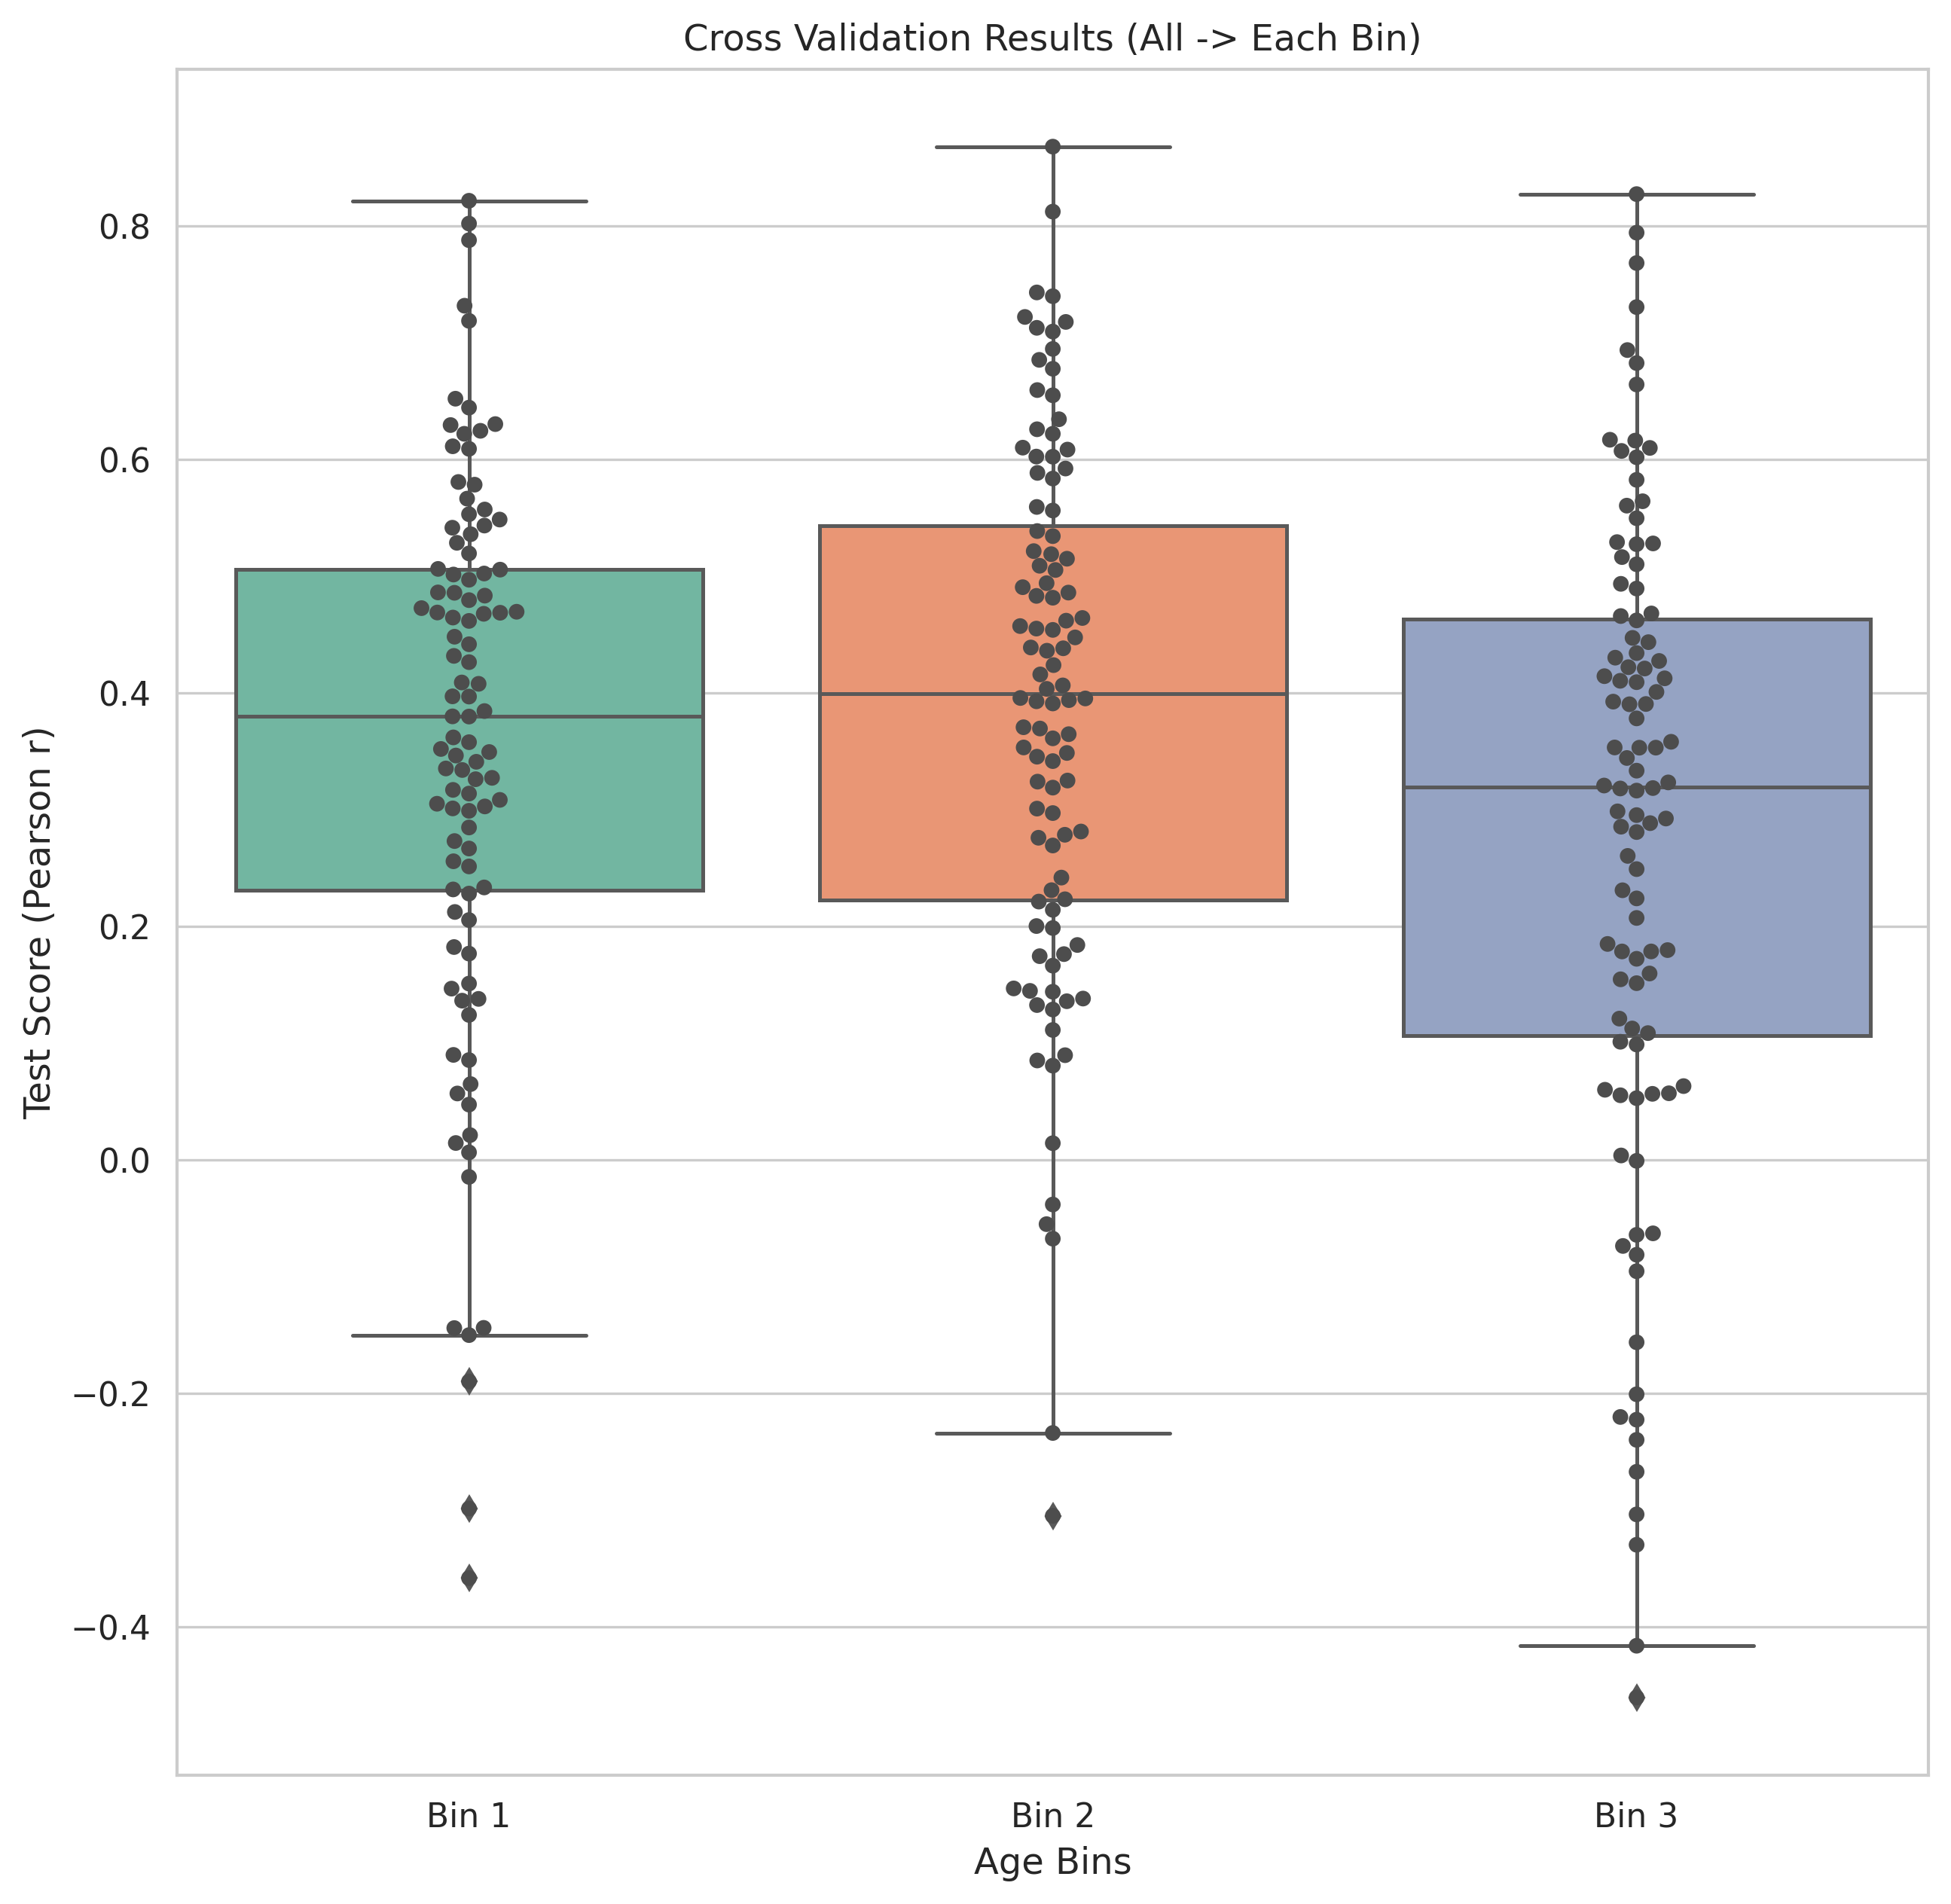

In [58]:
results = pd.DataFrame(dict(zip(bin_test_labels, bin_test_scores)))

ax = sns.boxplot(data=results, palette="Set2")
ax = sns.swarmplot(data=results, color="0.3", order=bin_test_labels)
ax.set_ylabel('Test Score (Pearson r)')
ax.set_xlabel('Age Bins')
ax.set_title('Cross Validation Results (All -> Each Bin)')

In [56]:
bin_1_coefs = coefs.copy()

In [53]:
bin_2_coefs = coefs.copy()

In [50]:
bin_3_coefs = coefs.copy()

### ICC

In [ ]:
%%time
import pingouin as pg

group_one = pd.DataFrame(np.squeeze(np.array(bin_2_coefs), axis=2))
group_one['group'] = 'g1'

group_two = pd.DataFrame(np.squeeze(np.array(bin_3_coefs), axis=2))
group_two['group'] = 'g2'

group_one_two = pd.concat([group_one, group_two])
icc_data = pd.melt(group_one_two, id_vars='group', var_name='connection', 
                   value_name='weight', ignore_index=False)
# display(icc_data)

icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='group', ratings='weight').round(3)
icc.set_index("Type")